In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import time
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
import zlib

In [2]:
def hash_name(name):
    return format(zlib.crc32(name.encode()), '08x')  # 8桁の16進数として返す

In [3]:
p = Path('input/scraping_data/')
shop_files = list(p.glob('shop_info_page*.csv'))
review_files = list(p.glob('reviews_page*.csv'))

dfs = []
for shop_file in shop_files:
    df = pd.read_csv(shop_file)
    dfs.append(df)
shop_info = pd.concat(dfs, ignore_index=True)

dfs = []
for review_file in review_files:
    df = pd.read_csv(review_file)
    dfs.append(df)
review = pd.concat(dfs, ignore_index=True)

shop_info

In [4]:
# shop_infoの重複を削除
before_len = len(shop_info)
shop_info = shop_info.drop_duplicates(subset='shop_name')
after_len = len(shop_info)
print(f'dropped {before_len - after_len} duplicates')

dropped 3 duplicates


In [5]:
# 匿名化
shop_info['shop_id'] = shop_info['shop_name'].apply(hash_name)

In [6]:
usecols = ['shop_id', 'open_date', 'lunch_budget', 'dinner_budget', 'holiday', 'nearest_station']
shop_info = shop_info[usecols].copy()
shop_info.to_csv('output/competition_data/shop_info.csv', index=False)
shop_info.head()

,shop_id,open_date,lunch_budget,dinner_budget,holiday,nearest_station
0,09385a4b,2001年11月6日,"￥1,000～￥1,999","￥1,000～￥1,999",火曜日 第2第4の水曜日 (祝日関係なく休み),西長堀駅
1,e76cf39b,2010年6月18日,～￥999,"￥1,000～￥1,999",NaN,福島駅
2,1c4cb3ed,2012年4月12日,～￥999,～￥999,NaN,南方駅
3,b623d137,2016年4月23日,～￥999,～￥999,NaN,福島駅
4,87598b23,2018年5月19日,～￥999,NaN,NaN,中津駅（大阪メトロ）


reviews

In [7]:
# drop duplicates
before_len = len(review)
review = review.drop_duplicates()
after_len = len(review)
print(f'dropped {before_len - after_len} duplicates')

dropped 24000 duplicates


In [8]:
# commentが空の行を削除
before_len = len(review)
review = review[review['comment'].notnull()].copy()
after_len = len(review)
print(f'dropped {before_len - after_len} rows with null comment')

dropped 17661 rows with null comment


In [9]:
# review_scoreが空の行を削除
before_len = len(review)
review = review[review['review_score'].notnull()].copy()
after_len = len(review)
print(f'dropped {before_len - after_len} rows with null review_score')

dropped 25 rows with null review_score


In [10]:
# review_scoreの-を削除
before_len = len(review)
review = review[review['review_score'] != '-'].copy()
after_len = len(review)
print(f'dropped {before_len - after_len} rows with "-" review_score')

dropped 1735 rows with "-" review_score


<Axes: >

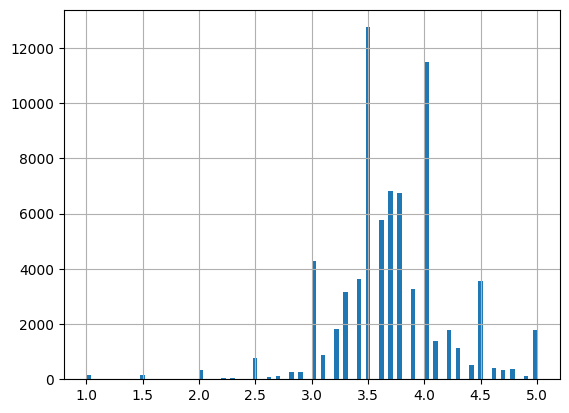

In [11]:
# 数値型に変換
review['review_score'] = review['review_score'].astype(float)
review['review_score'].hist(bins=100)

In [12]:
# visit_dateが正しい書式のものだけ残す
before_len = len(review)
pattern = r'^\d{4}/\d{2}訪問$'
review = review[review['visit_date'].str.match(pattern)].copy()
after_len = len(review)
print(f'dropped {before_len - after_len} rows with invalid visit_date')

dropped 4342 rows with invalid visit_date


In [13]:
# visit_dateから年と月を抽出
review['visit_year'] = review['visit_date'].str[0:4].astype(int)
review['visit_month'] = review['visit_date'].str[5:7].astype(int)

<Axes: >

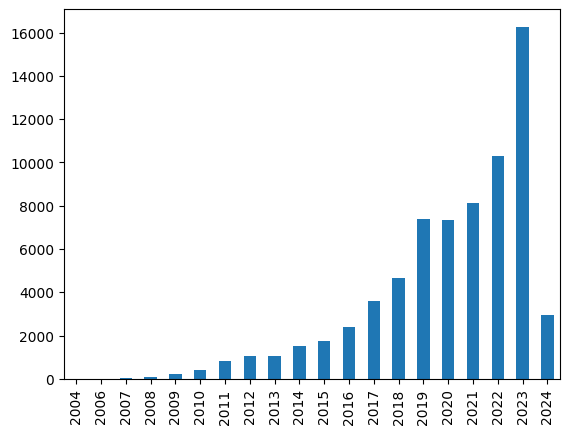

In [14]:
# visit_yearごとの件数を可視化
visit_year_count = review['visit_year'].value_counts().sort_index()
visit_year_count.plot(kind='bar')

In [15]:
# csvを開いたときに列が崩れるのでセミコロン、tabを変換
review['title'] = review['title'].str.replace(';', ' ')
review['comment'] = review['comment'].str.replace(';', ' ')
review['title'] = review['title'].str.replace('\t', ' ')
review['comment'] = review['comment'].str.replace('\t', ' ')
review['reviewer_name'] = review['reviewer_name'].str.replace(';', '')
review['reviewer_name'] = review['reviewer_name'].str.replace('\t', '')

In [16]:
# 匿名化
review['shop_id'] = review['shop_name'].apply(hash_name)
review['reviewer_id'] = review['reviewer_name'].apply(hash_name)

In [17]:
# id列を作成({shop_id}_{reviewer_id})
review['id'] = review['shop_id'] + '_' + review['reviewer_id']

In [18]:
# 並び順をシャッフル
review = review.sample(frac=1, random_state=0).reset_index(drop=True)

In [19]:
# trainとtestを分割
# train(2022以前のデータ)とtest(2023年のデータ)に分割
train = review[review['visit_year'] <= 2022].reset_index(drop=True)
test = review[review['visit_year'] == 2023].reset_index(drop=True)

In [20]:
review

,shop_name,title,comment,reviewer_name,visit_date,review_cnt,review_score,visit_year,visit_month,shop_id,reviewer_id,id
0,麦と麺助,きれいだけどしっかりしたイリコスープの絶品ラーメン,特製イリコそば（1200円）リニューアルしてからレギュラーメニューは初めて食べます(^_-)...,なぎぴ813,2021/01訪問,4.0,4.9,2021,1,87598b23,d57b35ba,87598b23_d57b35ba
1,時屋,いままでで一番のつけ麺,開店とほぼ同時刻に来店。店内満席・既に6〜7人の行列ができていました。しかし、10〜15分ほ...,2525菅田将暉,2022/05訪問,1.0,4.3,2022,5,c204b5f7,66501bed,c204b5f7_66501bed
2,カドヤ食堂 総本店,煮干し中華そばワンタン味玉トッピング1600円,カドヤ食堂 総本店ここは7年ぶりの訪麺で以前は確かバイクできたような気がする。公式サイトにて...,zuzuzuzu,2022/02訪問,2.0,4.0,2022,2,09385a4b,de6e1229,09385a4b_de6e1229
3,らーめん 伊藝,NaN,雨の日曜日開店前に到着‼️私も金の器で提供していただきました。（嬉）つけ麺は、中と半チャーハ...,0.52,2023/06訪問,1.0,4.0,2023,6,f7d5bfd5,895adf61,f7d5bfd5_895adf61
4,自己流ラーメン綿麺,ありふれた豚骨魚介つけ麺だからこそ違いが分かる名店でした,困りました。綿麺ですがレビューが浮かばない。それもこれもルーフランクさんの素晴らしいレビュー...,メイクマイデイ,2015/06訪問,1.0,4.6,2015,6,40f52d87,17ee8036,40f52d87_17ee8036
...,...,...,...,...,...,...,...,...,...,...,...,...
70044,大阪中華サワダ飯店,サワダ式中華バル第二弾！梅田の真ん中にオープン‼︎,2021.1.15ミシュラン一つ星の【中華菜エスサワダ】さんの、新店舗が梅田の真ん中にオープ...,ひろっし(会長),2021/01訪問,1.0,4.0,2021,1,d8afd764,08e34ef0,d8afd764_08e34ef0
70045,手打ち麺 やす田,NaN,麺のモチモチ感は半端なく良かったです✨スープにもう少しコクが欲しかったです。でも美味しかった...,タッキーfreude,2017/12訪問,1.0,3.4,2017,12,2f2d1424,3c3afbcf,2f2d1424_3c3afbcf
70046,総大醤,NaN,初めて来店しました。いつ見ても長蛇の列で一度行ってみたいと思っていました。丁度昼を過ぎていて...,reals34,2022/12訪問,1.0,2.5,2022,12,13f09ce1,e868d15f,13f09ce1_e868d15f
70047,らーめん弥七,NaN,へためし(チャーシュー丼)最高！ラーメンは好み。,shinn0124,2017/10訪問,1.0,3.5,2017,10,3efd8434,3fbd2942,3efd8434_3fbd2942


In [21]:
usecols = ['id', 'shop_id', 'reviewer_id', 'title', 'comment', 'visit_year', 'visit_month', 'review_score']
train = train[usecols].copy()
train.to_csv('output/competition_data/train.csv', index=False)
train.head()

,id,shop_id,reviewer_id,title,comment,visit_year,visit_month,review_score
0,87598b23_d57b35ba,87598b23,d57b35ba,きれいだけどしっかりしたイリコスープの絶品ラーメン,特製イリコそば（1200円）リニューアルしてからレギュラーメニューは初めて食べます(^_-)...,2021,1,4.9
1,c204b5f7_66501bed,c204b5f7,66501bed,いままでで一番のつけ麺,開店とほぼ同時刻に来店。店内満席・既に6〜7人の行列ができていました。しかし、10〜15分ほ...,2022,5,4.3
2,09385a4b_de6e1229,09385a4b,de6e1229,煮干し中華そばワンタン味玉トッピング1600円,カドヤ食堂 総本店ここは7年ぶりの訪麺で以前は確かバイクできたような気がする。公式サイトにて...,2022,2,4.0
3,40f52d87_17ee8036,40f52d87,17ee8036,ありふれた豚骨魚介つけ麺だからこそ違いが分かる名店でした,困りました。綿麺ですがレビューが浮かばない。それもこれもルーフランクさんの素晴らしいレビュー...,2015,6,4.6
4,15316161_6f08d431,15316161,6f08d431,｢鯛白湯とろり+燻製玉子｣&｢鯛めし｣,大阪市淀川区にある「鯛白湯らーめん ○de▽」さんに来店しました。お店は御堂筋線、JRの「新...,2019,6,4.5


In [22]:
test = test[usecols].copy()
test.drop(columns=['review_score']).to_csv('output/competition_data/test.csv', index=False)
test.drop(columns=['review_score']).head()

,id,shop_id,reviewer_id,title,comment,visit_year,visit_month
0,f7d5bfd5_895adf61,f7d5bfd5,895adf61,NaN,雨の日曜日開店前に到着‼️私も金の器で提供していただきました。（嬉）つけ麺は、中と半チャーハ...,2023,6
1,1c4cb3ed_2338bfdf,1c4cb3ed,2338bfdf,線路沿いに並び。。,お店は二箇所に別れていて、並んでいる人を右へ左へと店舗に振られるので、長い並びは思っているよ...,2023,2
2,b623d137_b7c39a59,b623d137,b7c39a59,福島駅ラーメン激戦区の一店,大阪遠征するとまず福島でラーメン食べてから行動開始するんですが、三くか麺助か悩んだ結果、あま...,2023,3
3,5918225e_16263e26,5918225e,16263e26,NYジャパンフェスで世界3位の経歴もつ上新庄で人気なラーメン屋,【今回紹介のお店】⚫︎KUCHE（クーシェ）✔︎NYジャパンフェスで世界3位受賞経歴あるラー...,2023,1
4,aba6367e_a5640176,aba6367e,a5640176,NaN,投稿時：3.73こちらのお店は 阪急梅田駅の改札内にあるので阪急電車を利用しない人は入場券が...,2023,5


In [23]:
labels = test[['id', 'review_score']].copy()
labels.to_csv('output/competition_data/labels.csv', index=False)
labels.head()

,id,review_score
0,f7d5bfd5_895adf61,4.0
1,1c4cb3ed_2338bfdf,3.7
2,b623d137_b7c39a59,4.5
3,5918225e_16263e26,3.4
4,aba6367e_a5640176,3.8


In [24]:
sample_submission = test[['id']].copy()
sample_submission['review_score'] = 3.0
sample_submission.to_csv('output/competition_data/sample_submission.csv', index=False)
sample_submission.head()

,id,review_score
0,f7d5bfd5_895adf61,3.0
1,1c4cb3ed_2338bfdf,3.0
2,b623d137_b7c39a59,3.0
3,5918225e_16263e26,3.0
4,aba6367e_a5640176,3.0
